<a href="https://colab.research.google.com/github/smcantab/Examples/blob/master/ns_discrete_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nested Sampling for discrete parameter spaces and degenerate likelihoods

---

From Murray's thesis:

The progress of nested sampling is supposed to be independent of the likelihood function. The procedures that estimate quantities based on nested sampling results rely on this behavior. As an example, the geometric mean path suggests that with $N = 100$ particles nested sampling should typically get to $x = 0.1$ after about $−100 \log 0.1 ≈ 230$ iterations. Now consider running nested sampling algorithm on a problem with the following likelihood function:

$$
L(x) =
\begin{cases}
0.5 & 0\leq x \leq 0.1 \\
0.01 & 0.1 < x \leq 1  
\end{cases}
$$

After drawing $N = 100$ particles from the prior about $90$ of them will have $x > 0.1$ and $L=0.01$. If the inequality $L(\theta^{(s)})>L(\theta^{(s−1)})$ is strictly enforced all new particles must have $L>0.01$ and therefore $x<0.1$. Therefore $x=0.1$ will be reached in about $s=90$ iterations, leading to very wrong results. If instead $L(\theta^{(s)})≥L(\theta^{(s−1)})$ is enforced the results will still be wrong: $x=0.1$ will not be reached until about iteration $s=900$

Solving the degeneracy problem requires imposing a total ordering on the $\mathrm{d}x$ elements. Earlier presentations of nested sampling (Skilling, 2006) suggest introducing an auxiliary labeling of the states, $\ell(\theta)$ that resolves likelihood ties. It was suggested these labels could be chosen arbitrarily:  

*“Random samples from Uniform[0, 1] suffice, as would a cryptographic identification key derived from $\theta$, or almost anything else.”*

However, a fixed key does not solve the problem with discrete parameters. If the $0.1<x<1$ plateau in the example above originated from a single discrete $\theta$ setting, then all the $\mathrm{d}x$ elements in this range would receive the same cryptographic key. Likelihood ties would still be unresolved. If random labels are employed and always regenerated on repeated observations of the same $\theta$ then nested sampling will give the correct results.

Skilling (2007) mentions a better way of thinking about the random ‘labels’. Instead of an extra piece of information attached to each parameter setting, $\ell$ is an extra input variable for an extended problem with a likelihood that depends on $\theta$ and $\ell$. The distinction may seem fine: on large problems the same $\theta$ location will rarely be revisited. But getting this right is important for obtaining correct answers on small test problems.

The auxiliary joint distribution is over the variables of interest θ and an independent variable $\ell \in [0, 1]$:

$$\begin{aligned}
p(\theta, \ell) = p(\theta) p(\ell) &= \frac{1}{Z} L(\theta) \pi(\theta) \frac{1}{Z_\ell} L_0(\ell) \pi_0(\ell)\\
&= \frac{1}{Z} L_J(\theta, \ell) \pi(\theta)
\end{aligned}
$$

where $L_J(\theta, \ell)=L(\theta)L_0(\ell)$, $L_0(\ell)=1+\epsilon(\ell-0.5)$, $\pi_0(\ell)=1$ and $Z_\ell$=1. Standard nested sampling is now possible. At each iteration $L_J(\theta,\ell)$ must increase. We can choose $\epsilon$ such that $\log(\epsilon)$ is smaller than the smallest difference in $\log(L(\theta))$ allowed by machine precision. This ensures the auxiliary variable $\ell$ will only matter when $L(\theta)=L(\theta^{(s−1)})$.

---

Below I implement the serial and parallel versions of NS using the strategy above to show that, indeed, it works.

First I do this adding a random number of the order $10^{-7}$ to the likelihood estimates. This works, but crucially the magnitude of the noise term matters in order for the floating point comparison to work. I find that `np.finfo(np.float32).eps * (np.random.uniform())` is what it takes. If instead we use `np.finfo(np.float32).eps` or 10 or 100 times as much, it does not work.

Then I do the same but associate with each likelihood a random number $\ell \in [0, 1)$ to break ties. This is very robust and insightful as one can see what the progression in the random numbers used to break the ties is. It turns out that at every iteration the number of points taking a discrete discrete value e.g., $L(x)=0.01$ is such that it takes approximately $−100 \log 0.1 ≈ 230$ steps to cover the entire range of $[0, 1)$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
frac=0.1
def __logLhood(x, addnoise=False):
    if x < frac:
        y = 1.
    if x >= frac:
        y = 2.
    if addnoise is True:
        y += np.finfo(np.float32).eps * (np.random.uniform())
    return y

logLhood = np.vectorize(__logLhood)

def sort_pair(x, lhl):
    idx = lhl.argsort()
    return x[idx], lhl[idx]

def sort_triple(x, lhl, sortidx):
    tmp = np.hstack((x.reshape(-1,1), lhl.reshape(-1,1), sortidx.reshape(-1,1))).tolist()
    tmp = np.array(sorted(tmp, key=lambda x: (x[1], x[2])))
    x, lhl, sortidx = tmp[:,0],tmp[:, 1],tmp[:, 2]
    return x, lhl, sortidx

def get_lhl_sorted(x, addnoise=False):
    lhl = logLhood(x, addnoise=addnoise)
    idx = lhl.argsort()
    return x[idx], lhl[idx]

In [ ]:
# serial with jitter
k = 100
print('expected nsteps = {}'.format(np.log(1-frac)/np.log(k/(k+1))))
print('expected compression = {}'.format(1-frac))
x = np.random.uniform(size=k)
x, lhl = get_lhl_sorted(x, addnoise=True)
out = []
for i in range(1000):
    x, lhl = sort_pair(x, lhl)
    xmin, lhlmin = x[0], lhl[0]
#     print(xmin, lhlmin)
    out.append(lhlmin)
    if lhlmin >= 2:
        break
    while True:
        trx = np.random.uniform()
        trlhl = logLhood(trx, addnoise=True)
        if trlhl > lhlmin:
            break
    x[0], lhl[0] = trx, trlhl
out = np.array(out)
n = out.size
print('NS nsteps = {}'.format(n))
print('NS compression = {}'.format((k/(k+1))**n))
# test that out is sorted
for i in range(out.size-1):
    if out[i+1]-out[i] <= 0:
        print(i, out[i], out[i+1])
        break

expected nsteps = 10.588644459423223
expected compression = 0.9
NS nsteps = 10
NS compression = 0.9052869546929833


In [ ]:
# parallel with jitter
k = 100
print('expected nsteps = {}'.format(np.log(1-frac)/np.log(k/(k+1))))
print('expected compression = {}'.format(1-frac))
x = np.random.uniform(size=k)
x, lhl = get_lhl_sorted(x, addnoise=True)
out = []
for _ in range(1000):
    x, lhl = sort_pair(x, lhl)
    xmin, lhlmin = x[0], lhl[0]
    out.append(lhlmin)
    if lhlmin >= 2:
        break
    for i in range(x.size):
        while True:
            trx = np.random.uniform()
            trlhl = logLhood(trx, addnoise=True)
            if trlhl > lhlmin:
                break
        x[i], lhl[i] = trx, trlhl
out = np.array(out)
n = out.size
print('NS nsteps = {}'.format(n))
print('NS compression = {}'.format((k/(k+1))**n))
# test that out is sorted
for i in range(out.size-1):
    if out[i+1]-out[i] <= 0:
        print(i, out[i], out[i+1])
        break

expected nsteps = 10.588644459423223
expected compression = 0.9
NS nsteps = 8
NS compression = 0.9234832224823122


expected nsteps = 10.588644459423223
expected compression = 0.9
NS nsteps = 11
NS compression = 0.8963237175178052


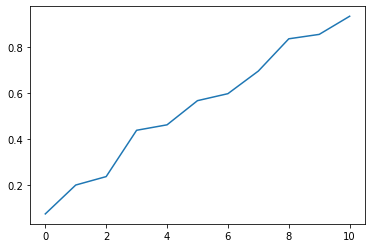

In [ ]:
# serial with sorting idx
k = 100
print('expected nsteps = {}'.format(np.log(1-frac)/np.log(k/(k+1))))
print('expected compression = {}'.format(1-frac))
x = np.random.uniform(size=k)
lhl = logLhood(x, addnoise=False)
sortidx = np.random.uniform(size=x.size)
# sortidx = np.random.randint(np.iinfo(np.int64).max, size=x.size)
x, lhl, sortidx = sort_triple(x, lhl, sortidx)
out,  outx, outidx = [],[],[]
for i in range(1000):
    x, lhl, sortidx = sort_triple(x, lhl, sortidx)
    xmin, lhlmin, idxmin = x[0], lhl[0], sortidx[0]
    if lhlmin >= 2:
        break
    out.append(lhlmin)
    outx.append(xmin)
    outidx.append(idxmin)
    while True:
        trx = np.random.uniform()
        trlhl = logLhood(trx, addnoise=False)
        tridx = np.random.uniform()
#         tridx = np.random.randint(np.iinfo(np.int64).max)
        if (trlhl > lhlmin):
            break
        if (np.isclose(trlhl, lhlmin) and tridx > idxmin):
            break
    x[0], lhl[0], sortidx[0] = trx, trlhl, tridx
out = np.array(out)
n = out.size
print('NS nsteps = {}'.format(n))
print('NS compression = {}'.format((k/(k+1))**n))
plt.plot(outidx)
# plt.plot(outx)

expected nsteps = 10.588644459423223
expected compression = 0.9
NS nsteps = 10
NS compression = 0.9052869546929833


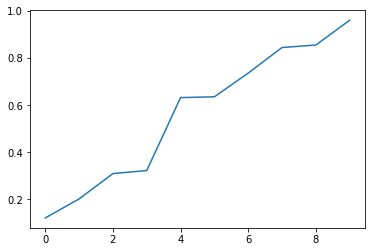

In [ ]:
# parallel with sorting idx
k = 100
print('expected nsteps = {}'.format(np.log(1-frac)/np.log(k/(k+1))))
print('expected compression = {}'.format(1-frac))
x = np.random.uniform(size=k)
lhl = logLhood(x, addnoise=False)
sortidx = np.random.uniform(size=x.size)
# sortidx = np.random.randint(np.iinfo(np.int64).max, size=x.size)
x, lhl, sortidx = sort_triple(x, lhl, sortidx)
out,  outx, outidx = [],[],[]
for _ in range(1000):
    x, lhl, sortidx = sort_triple(x, lhl, sortidx)
    xmin, lhlmin, idxmin = x[0], lhl[0], sortidx[0]
    if lhlmin >= 2:
        break
    out.append(lhlmin)
    outx.append(xmin)
    outidx.append(idxmin)
    for i in range(x.size):
        while True:
            trx = np.random.uniform()
            trlhl = logLhood(trx, addnoise=False)
            tridx = np.random.uniform()
#             tridx = np.random.randint(np.iinfo(np.int64).max)
            if (trlhl > lhlmin):
                break
            if (np.isclose(trlhl, lhlmin) and tridx > idxmin):
                break
        x[i], lhl[i], sortidx[i] = trx, trlhl, tridx
out = np.array(out)
n = out.size
print('NS nsteps = {}'.format(n))
print('NS compression = {}'.format((k/(k+1))**n))
plt.plot(outidx)
# plt.plot(outx)